# INTRODUCTION

This notebook was created by Aditya Vishwanthan to fulfil the requirements for the IBM Advanced Data Science Capstone course which was undertaken in June 2021.

>Problem Statement : Predict weekly S&P 500 returns (direction/magnitude) using investor positioning data. 

Investor positioning is determined by the commitment of traders reports which are released weekly by the Commodity Futures Trading Commission (CFTC) (https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalViewable/index.htm). Each report covers 3 classes of investors: 

<ul>
    <li> Non-commercials (NC): represent the "Smart Money" hedge funds and investment banks who are able to considerably move markets. 
    <li> Commercials (C): also "Smart Money" but typically use markets as a way to hedge against their position. 
    <li> Nonreportables (NR): retail investors known as the "Dumb Money" who are often on the wrong side of trades.
</ul>

The reports define the commitments of each investor class, either "Long" (betting the market will go up), or "Short" (betting the market will go down).

In [11]:
import os
import re
import math
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.request import urlopen
from pandas_datareader import data as datar

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pandas.plotting import register_matplotlib_converters
pd.options.mode.chained_assignment = None
register_matplotlib_converters()

# EXTRACT, TRANSFORM, LOAD (ETL)

In [2]:
def extract_and_transform_data():
    # S&P 500 closing prices
    sandpclosing = datar.DataReader("^GSPC", 
                           start='2010-6-16', 
                           end='2021-6-15', 
                           data_source='yahoo')['Adj Close']
    # COT report data
    dates = pd.date_range('6/15/2010','6/16/2021',freq='7d')
    data = []
    for date in dates:
        date_str = date.strftime('%Y/%m/%d')  
        price = 0
        try:
            price=sandpclosing[date]
        except:
            print('Price Exception for '+date_str)  # stock market closed on this day (manually insert values into CSV)
        url = "https://www.cftc.gov/sites/default/files/files/dea/cotarchives/"+date_str[0:4]+"/options/deacmesof"+date_str[5:7]+date_str[8:10]+date_str[2:4]+".htm"
        commitments = [0,0,0,0,0,0,0,0,0,0]
        try:
            page = urlopen(url)
        except:
            print('URL Exception for '+date_str) # no COT report on this day (manually insert values into CSV)
        else:
            # scrape html to find S&500 commitments
            html = page.read().decode("utf-8")
            scraped = html[html.find('S&P 500 Consolidated - CHICAGO MERCANTILE EXCHANGE'):]
            scraped = scraped[scraped.find('OPEN INTEREST'):]
            commitments = list(map(int,re.findall("\d+", scraped.replace(',',''))[0:9]))   
        data.append([date_str]+[price]+commitments)   
    data = pd.DataFrame(data,columns=['Date','Price','OI','NC_SHORT','NC_LONG','NC_SPREAD','C_LONG','C_SHORT','TOT_LONG','TOT_SHORT','NR_LONG','NR_SHORT'])
    data.to_csv('price_and_commitments_sandp.csv',index=False)
    return data
  
# load dataset
data = []
if os.path.isfile('./price_and_commitments - sandp.csv'):
    df = pd.read_csv('price_and_commitments - sandp.csv',parse_dates=['Date'])
    print('Pulled data from csv file!')
else:
    print('No csv file exists, retrieving data from online...')
    df = extract_and_transform_data()
    print('Scraped the web and created a new csv file!')

Pulled data from csv file!


In [3]:
df.head()

,Date,Price,OI,NC_SHORT,NC_LONG,NC_SPREAD,C_LONG,C_SHORT,TOT_LONG,TOT_SHORT,NR_LONG,NR_SHORT
0,2010-06-15,1115,1315726,63790,82674,109606,928351,928232,1101747,1120512,213979,195214
1,2010-06-22,1095,928668,69748,79661,45838,656760,672299,772346,797799,156322,130869
2,2010-06-29,1041,1006178,72021,73942,75006,698782,724016,845808,872964,160370,133214
3,2010-07-06,1028,1033964,63304,89419,82736,720076,716278,866116,888434,167847,145530
4,2010-07-13,1095,1014184,62584,101044,74728,719310,684630,856622,860402,157562,153782


# FEATURE ENGINEERING

In [4]:
# remove unneeded columns
df.drop(columns=['NC_SPREAD','TOT_LONG','TOT_SHORT'],inplace=True)

# calculate relevant feature ratios for NC, NR, C , and remove unneeded columns
df['NC_TOT_OI'] = (df['NC_LONG']+df['NC_SHORT'])/df['OI']
df['NR_TOT_OI'] = (df['NR_LONG']+df['NR_SHORT'])/df['OI']
df['C_TOT_OI'] = (df['C_LONG']+df['C_SHORT'])/df['OI']
df['C_LONG_SHORT'] = (df['C_LONG']-df['C_SHORT'])/(df['C_LONG']+df['C_SHORT'])
df['NC_LONG_SHORT'] = (df['NC_LONG']-df['NC_SHORT'])/(df['NC_LONG']+df['NC_SHORT'])
df['NR_LONG_SHORT'] = (df['NR_LONG']-df['NR_SHORT'])/(df['NR_LONG']+df['NR_SHORT'])
df.drop(columns=['NC_SHORT','NC_LONG','NR_LONG','NR_SHORT','C_LONG','C_SHORT'],inplace=True)

# calculate weekly return as dependent variable
df['Return'] = df['Price'].pct_change()
df['Return'].iloc[0] = 0

# calculate direction of return (1 for up, 0 for down) as dependent variable
df['Direction'] = [1 if i>=0 else 0 for i in df['Return']]

In [5]:
df.head()

,Date,Price,OI,NC_TOT_OI,NR_TOT_OI,C_TOT_OI,C_LONG_SHORT,NC_LONG_SHORT,NR_LONG_SHORT,Return,Direction
0,2010-06-15,1115,1315726,0.111318,0.311002,1.411071,0.000064,0.128933,0.045859,0.000000,1
1,2010-06-22,1095,928668,0.160885,0.309250,1.431145,-0.011692,0.066348,0.088627,-0.017937,0
2,2010-06-29,1041,1006178,0.145067,0.291781,1.414062,-0.017735,0.013161,0.092498,-0.049315,0
3,2010-07-06,1028,1033964,0.147706,0.303083,1.389172,0.002644,0.170996,0.071215,-0.012488,0
4,2010-07-13,1095,1014184,0.161340,0.306990,1.384305,0.024702,0.235045,0.012141,0.065175,1


# DATA EXPLORATION AND VISUALIZATION

In [7]:
# initial dataset exploration (statistical summary)
df.describe()

,Price,OI,NC_TOT_OI,NR_TOT_OI,C_TOT_OI,C_LONG_SHORT,NC_LONG_SHORT,NR_LONG_SHORT,Return,Direction
count,575.000000,5.750000e+02,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000
mean,2195.422609,9.084559e+05,0.199147,0.249380,1.300182,-0.010777,-0.007244,0.047141,0.002536,0.638261
std,749.723812,1.376645e+05,0.028241,0.037821,0.102484,0.025219,0.141748,0.065519,0.020262,0.480922
min,1028.000000,5.908930e+05,0.097247,0.178837,1.042922,-0.066729,-0.314396,-0.097342,-0.122484,0.000000
25%,1550.000000,8.217550e+05,0.177260,0.221279,1.210471,-0.025754,-0.107348,-0.004996,-0.004949,0.000000
50%,2084.000000,8.976880e+05,0.200235,0.240168,1.295497,-0.012923,-0.014148,0.044761,0.004529,1.000000
75%,2739.500000,9.817490e+05,0.221403,0.273703,1.395676,0.003652,0.073699,0.099273,0.013281,1.000000
max,4247.000000,1.584910e+06,0.261105,0.386999,1.476208,0.059708,0.465707,0.194324,0.070327,1.000000


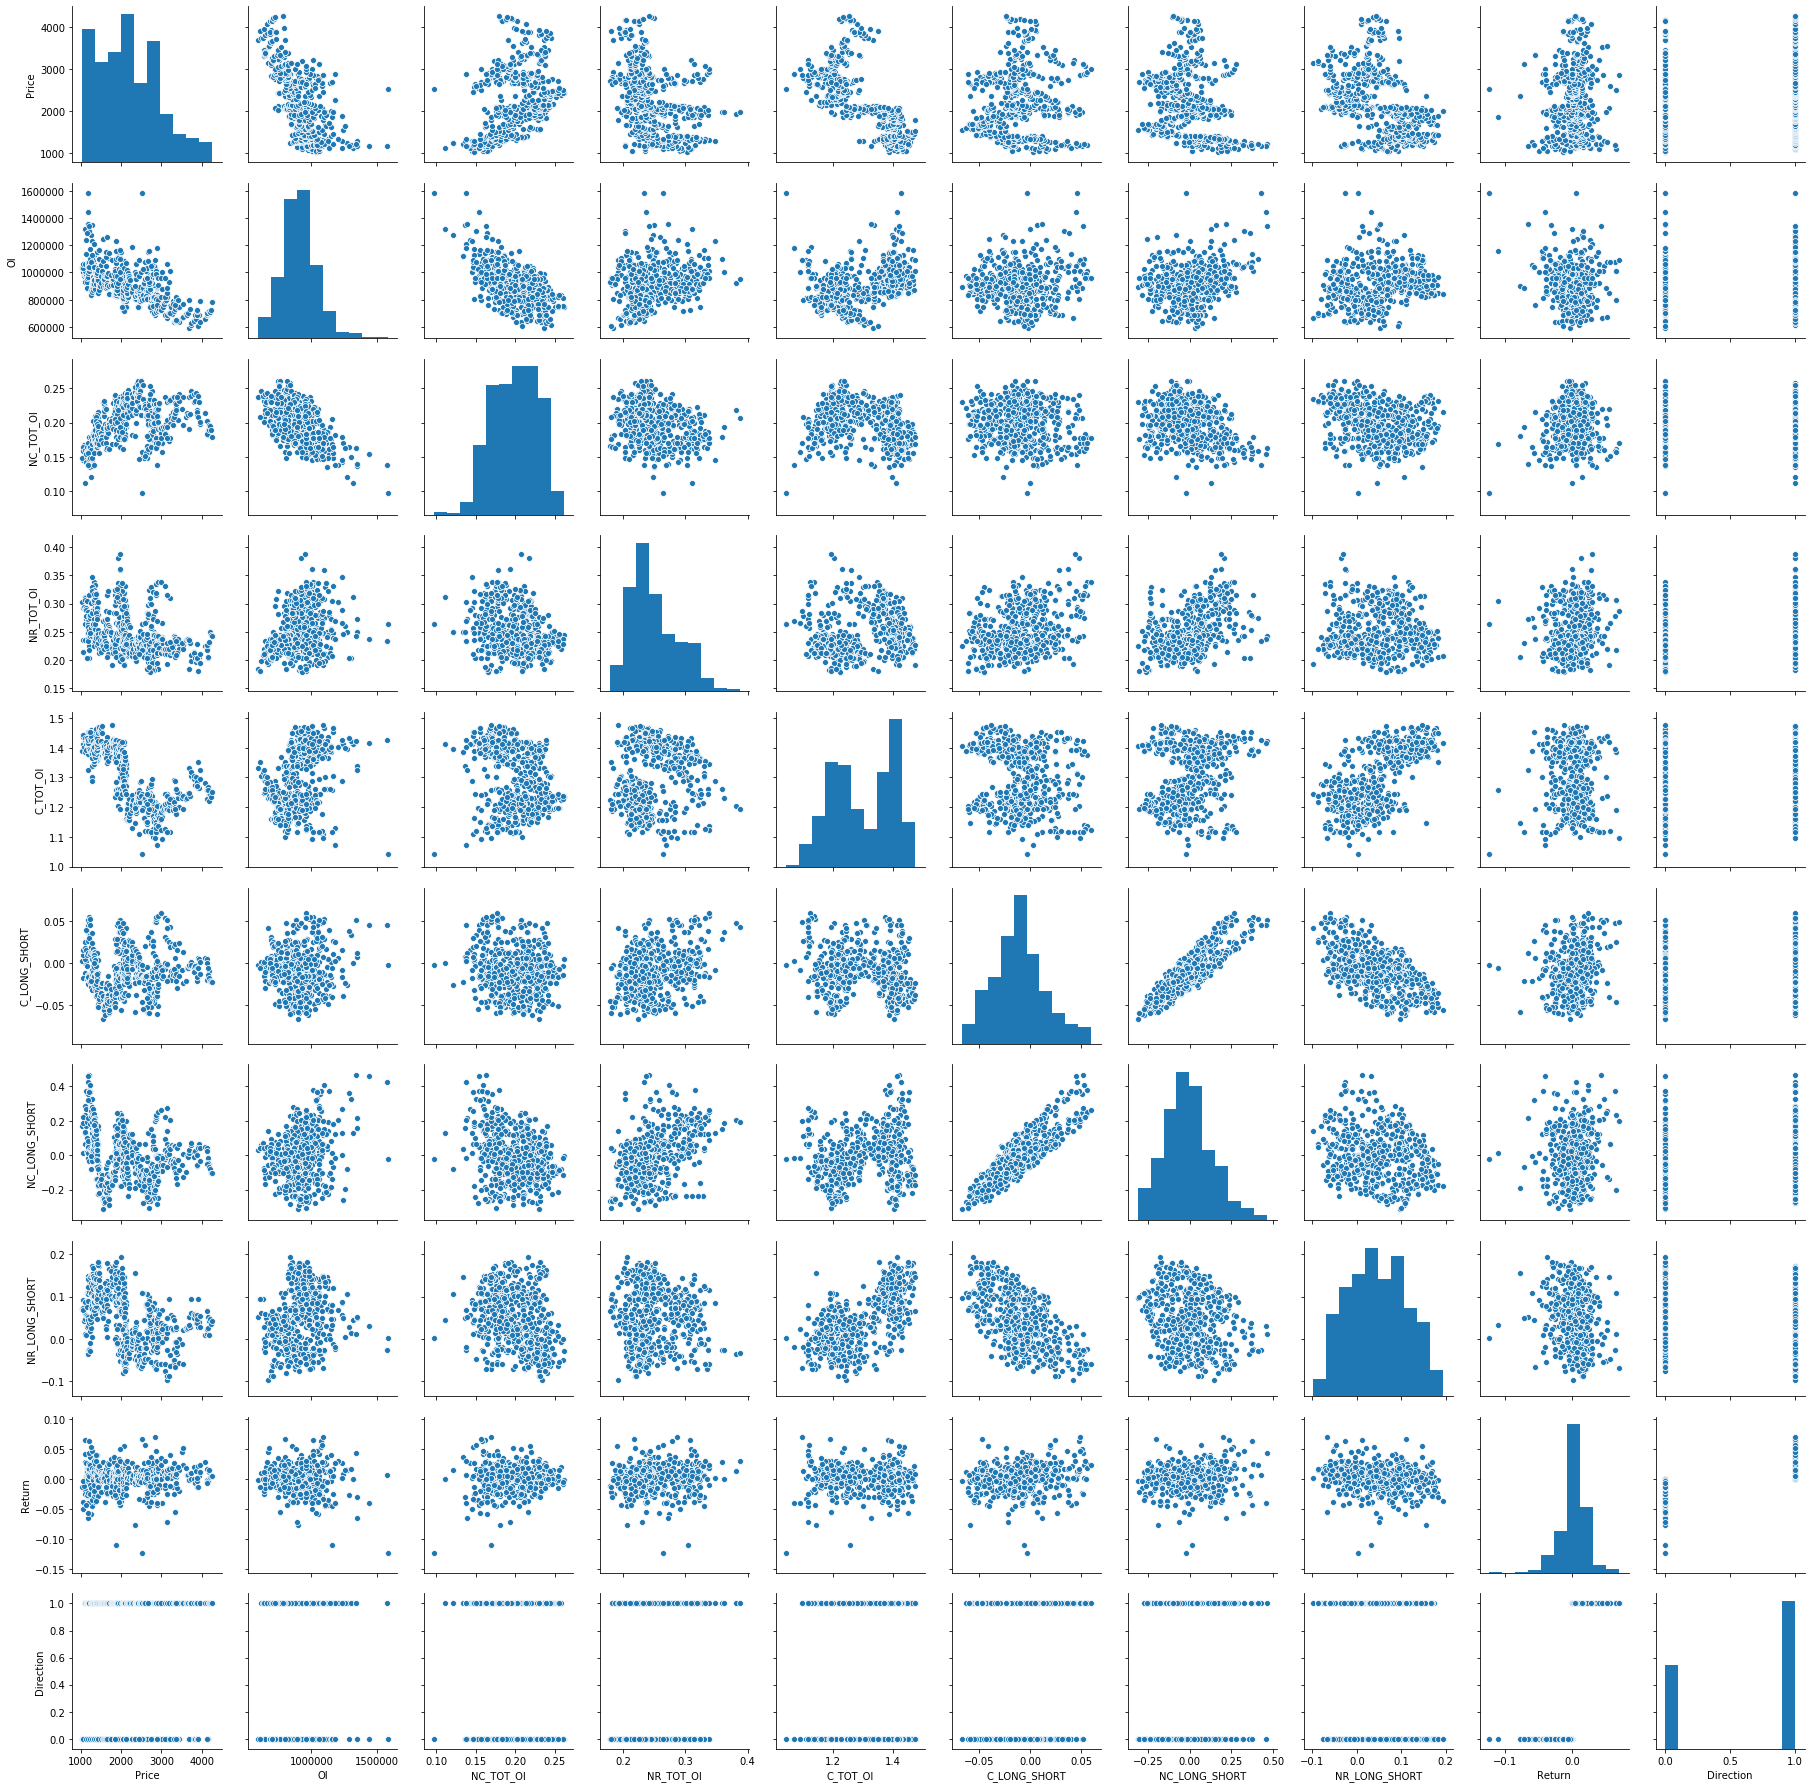

In [8]:
# feature univariate and bivariate distributions
sns.pairplot(df)

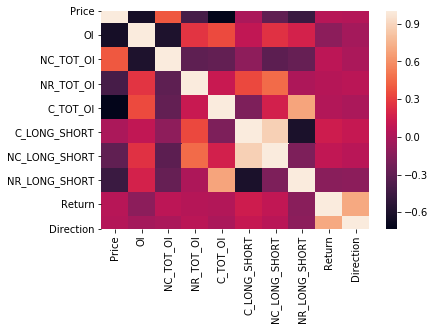

In [9]:
# feature correlation
corr = df.corr()
sns.heatmap(corr)

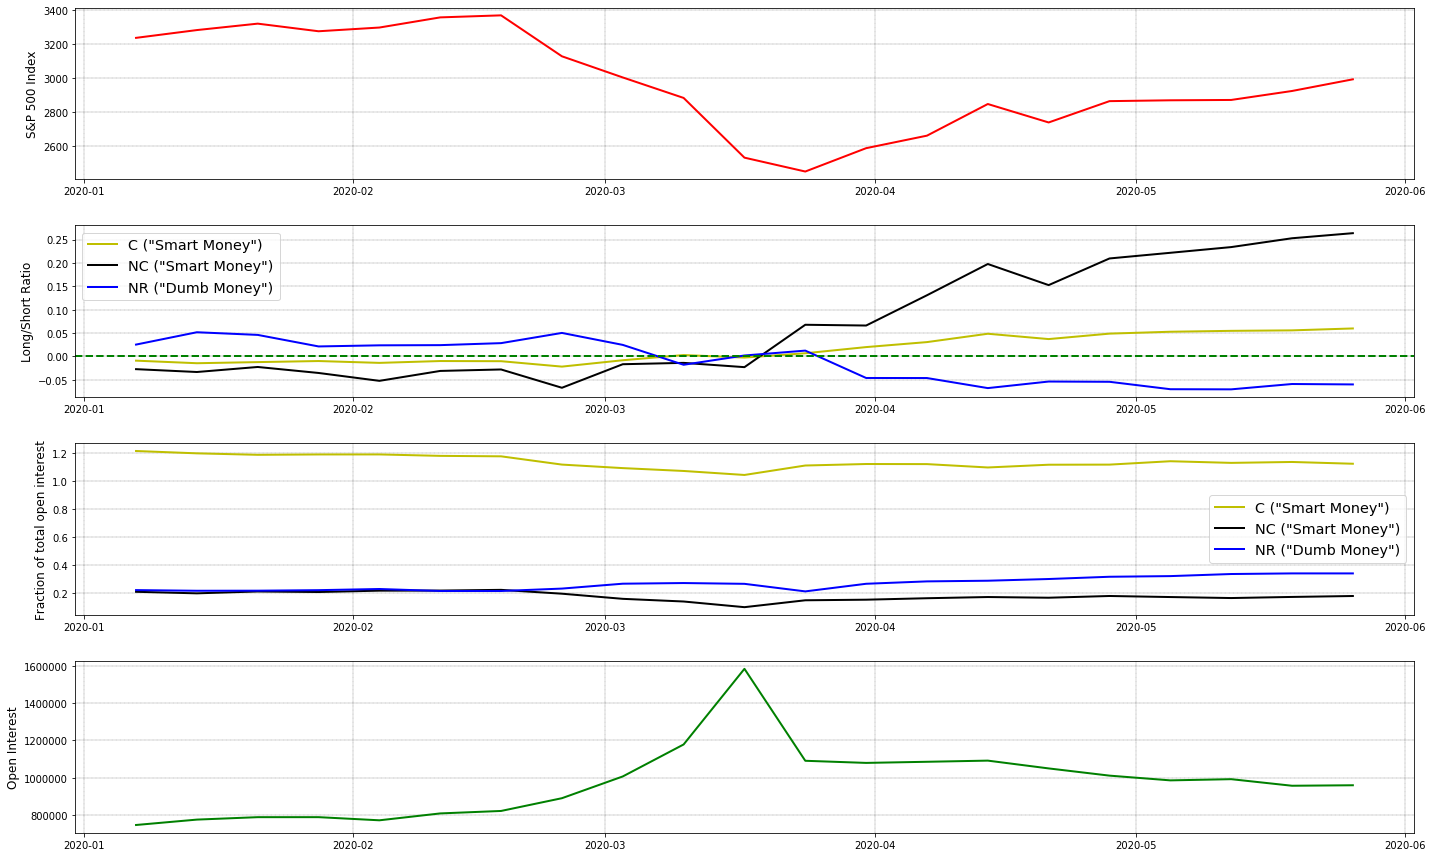

In [12]:
# visualise features and output during covid crash
to_plot = df.loc[(df['Date'] > '2020-01-01') & (df['Date'] <= '2020-06-01')] # COVID CRASH
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(411)
ax1.plot(to_plot['Date'],to_plot['Price'],lw=2,color='r')
ax1.grid(color='k', linestyle='--', linewidth=0.25)
ax1.set_ylabel('S&P 500 Index',fontsize=12)
ax2 = fig.add_subplot(412, sharex=ax1)
ax2.plot(to_plot['Date'],to_plot['C_LONG_SHORT'],lw=2,color='y',label='C ("Smart Money")')
ax2.plot(to_plot['Date'],to_plot['NC_LONG_SHORT'],lw=2,color='k',label='NC ("Smart Money")')
ax2.plot(to_plot['Date'],to_plot['NR_LONG_SHORT'],lw=2,color='b',label='NR ("Dumb Money")')
ax2.axhline(y=0,lw=2,ls='--',color='g')
ax2.set_ylabel('Long/Short Ratio',fontsize=12)
ax2.legend(fontsize='x-large')
ax2.grid(color='k', linestyle='--', linewidth=0.25)
ax3 = fig.add_subplot(413, sharex=ax1)
ax3.plot(to_plot['Date'],to_plot['C_TOT_OI'],lw=2,color='y',label='C ("Smart Money")')
ax3.plot(to_plot['Date'],to_plot['NC_TOT_OI'],lw=2,color='k',label='NC ("Smart Money")')
ax3.plot(to_plot['Date'],to_plot['NR_TOT_OI'],lw=2,color='b',label='NR ("Dumb Money")')
ax3.set_ylabel('Fraction of total open interest',fontsize=12)
ax3.legend(fontsize='x-large')
ax3.grid(color='k', linestyle='--', linewidth=0.25)
ax4 = fig.add_subplot(414, sharex=ax1)
ax4.plot(to_plot['Date'],to_plot['OI'],lw=2,color='g')
ax4.set_ylabel('Open Interest',fontsize=12)
ax4.grid(color='k', linestyle='--', linewidth=0.25)
plt.tight_layout(pad=1.0)

# DATA NORMALIZATION

In [38]:
# split data into X (features) and Y (output) 
X = df[['OI','NC_TOT_OI','NR_TOT_OI','C_TOT_OI','NC_LONG_SHORT','NR_LONG_SHORT','C_LONG_SHORT']]
Y = df['Return']

# normalize X data
X_normalizer = MinMaxScaler().fit(X)
X_scaled = X_normalizer.transform(X)
print(X_scaled.shape)

# normalize Y data
Y_normalizer = MinMaxScaler().fit(Y.values.reshape(-1,1))
Y_scaled = Y_normalizer.transform(Y.values.reshape(-1,1))
print(Y_scaled.shape)

(575, 7)
(575, 1)


# PRINCIPAL COMPONENT ANALYSIS (PCA)

Text(0, 0.5, 'Cumulative explained variance')

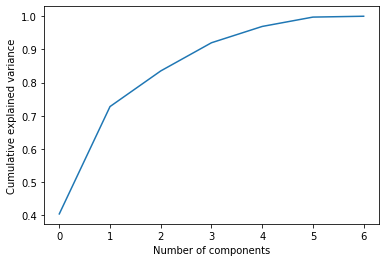

In [15]:
# use PCA to find the optimal features which capture the cumulative explained variance
pca = PCA(n_components=X.shape[1])
pca.fit(X_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [36]:
# NOTE: COMMENT THIS CODE OUT IF PCA SHOULD BE IGNORED
pca = PCA(n_components=4)
X_scaled = pca.fit_transform(X_scaled)
X_scaled = MinMaxScaler().fit_transform(X_scaled)
print(X_scaled.shape)

(575, 4)

# LOGISTIC REGRESSION USING XGBOOST 

This section looks at XGBoost and gradient boosted trees to predict direction of return from commitments data.

In [26]:
# define starting index for test data (anything before this is train)
test_start = int(0.8*len(X_scaled))

# split data into train and test sets
X_train, Y_train = X_scaled[:test_start,:], df['Direction'].iloc[:test_start].values
X_test, Y_test = X_scaled[test_start:,:], df['Direction'].iloc[test_start:].values

# hyper-parameters for XGBoost which are to be optimized
params = {
    "learning_rate" : [0.1, 0.2, 0.3],
    "max_depth" : [3, 5, 7],
    "min_child_weight" : [1, 3, 5]    
}

# define a cross-validation split for train/validation data
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# define xgboost classifier and perform grid search to optimize hyperparameters
clf = xgboost.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic',eval_metric='error')
grid_search = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=cv)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='error',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, 

In [27]:
# print best hyperparameters
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3}

In [28]:
# use optimal classifier and train 
clf = grid_search.best_estimator_
score = cross_val_score(clf, X_train, Y_train, cv=cv)
print('Training accuracy: {0:0.4f}'. format(score.mean()))

Training accuracy: 0.6826


In [29]:
# predict and print accuracy 
y_pred = clf.predict(X_test)
print('Test accuracy: {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Test accuracy: 0.6783


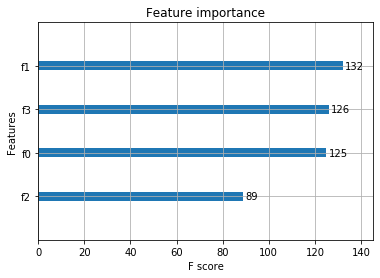

<Figure size 1152x864 with 0 Axes>

In [30]:
# plot xgboost feature importance
xgboost.plot_importance(clf)
plt.figure(figsize = (16, 12))
plt.show()

# PREDICTING RETURNS USING LSTM

This section looks at predicting future returns of S&P500 using past commitments and returns. 

In [31]:
# use n_past values to determine n_future return
n_future = 1
n_past = 5

# define train and test sets
X_train, Y_train, X_test, Y_test = [],[],[],[]
for i in range(n_past, len(X_scaled)-n_future+1):
    if i < test_start:
        X_train.append(X_scaled[i-n_past:i,:])
        Y_train.append(Y_scaled[i+n_future-1:i+n_future])
    else:
        X_test.append(X_scaled[i-n_past:i,:])
        Y_test.append(Y_scaled[i+n_future-1:i+n_future])
    
X_train, Y_train, X_test, Y_test = np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)

In [32]:
# create LSTM network
np.random.seed(1234)
tf.random.set_seed(1234)
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(tf.keras.optimizers.Adam(learning_rate=5e-3), loss='mse')
model.summary()

history = model.fit(X_train,Y_train,validation_split=0.2,epochs=200,batch_size=64,verbose=1,shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 64)             17664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

Epoch 71/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 72/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0129 - val_loss: 0.0119
Epoch 73/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 74/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 75/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 76/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 77/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 78/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 79/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 80/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 81/2

Epoch 153/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0097 - val_loss: 0.0118
Epoch 154/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0097 - val_loss: 0.0118
Epoch 155/200
6/6 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0118
Epoch 156/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0118
Epoch 157/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 158/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0096 - val_loss: 0.0118
Epoch 159/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0100 - val_loss: 0.0119
Epoch 160/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0096 - val_loss: 0.0118
Epoch 161/200
6/6 [==============================] - ETA: 0s - loss: 0.009 - 0s 15ms/step - loss: 0.0094 - val_loss: 0.0118
Epoch 162/200
6/6 [==============================] - 0s 13ms/step - loss: 0.

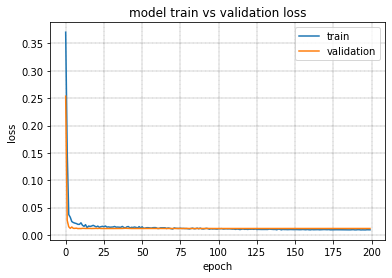

In [33]:
# plot loss metrics over epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(color='k', linestyle='--', linewidth=0.25)
plt.show()

In [34]:
# use trained model to predict train and test
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# inverse normalize
Y_train = Y_normalizer.inverse_transform(Y_train.reshape(-1,1))
Y_test  = Y_normalizer.inverse_transform(Y_test.reshape(-1,1))
train_predict = Y_normalizer.inverse_transform(train_predict)
test_predict = Y_normalizer.inverse_transform(test_predict)

# calculate mse's and accuracies
train_error = mean_squared_error(Y_train,train_predict)
test_error = mean_squared_error(Y_test,test_predict)
print('Training MSE Error: {0:0.4f}'. format(train_error))
print('Test MSE Error: {0:0.4f}'. format(test_error))

train_accuracies = [1 if np.sign(train_predict[i])==np.sign(Y_train[i]) else 0 for i in range(0,len(train_predict))]
test_accuracies = [1 if np.sign(test_predict[i])==np.sign(Y_test[i]) else 0 for i in range(0,len(test_predict))]
print('Training accuracy: {0:0.4f}'. format(sum(train_accuracies)/len(train_accuracies)))
print('Test accuracy: {0:0.4f}'. format(sum(test_accuracies)/len(test_accuracies)))

Training MSE Error: 0.0004
Test MSE Error: 0.0006
Training accuracy: 0.6154
Test accuracy: 0.6609


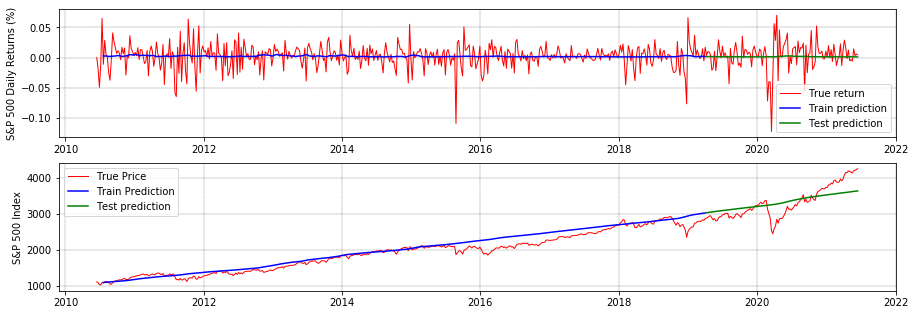

In [35]:
# plot return over time
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(311)
ax1.plot(df['Date'],df['Return'],'r',lw=1,label='True return')
ax1.plot(df['Date'].iloc[n_past+n_future-1:test_start+n_future-1],train_predict,'b',lw=1.5,label = 'Train prediction')
ax1.plot(df['Date'].iloc[test_start+n_future-1:],test_predict,'g',lw=1.5,label='Test prediction')
ax1.set_ylabel('S&P 500 Daily Returns (%)')
ax1.grid(color='k', linestyle='--', linewidth=0.25)
ax1.legend()

# plot price over time
ax2 = fig.add_subplot(312)
ax2.plot(df['Date'],df['Price'],'r',lw=1,label = 'True Price')
train_predict_price = []
for i in range(0,len(train_predict)):
    if i==0:     
        train_predict_price.append(df['Price'].iloc[n_past+n_future-2] * (1+train_predict[i]))
    else:
        train_predict_price.append(train_predict_price[i-1] * (1+train_predict[i]))
ax2.plot(df['Date'].iloc[n_past+n_future-1:test_start+n_future-1],train_predict_price,'b',lw=1.5,label='Train Prediction')
test_predict_price = []
for i in range(0,len(test_predict)):
    if i==0:     
        test_predict_price.append(train_predict_price[-1] * (1+test_predict[i]))
    else:
        test_predict_price.append(test_predict_price[i-1] * (1+test_predict[i]))
ax2.plot(df['Date'].iloc[test_start+n_future-1:],test_predict_price,'g',lw=1.5,label='Test prediction')
ax2.set_ylabel('S&P 500 Index')
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.25)